## Instructions

In this ~bonus lab~ business case study, you will be using the Sakila database of movie rentals. Choose one of the cases below, or both if you dare:

**Case 1:**

We will be trying to predict if a **customer will be renting a film** this month based on their previous activity and other details. We will first construct a table with:

    Customer ID
    City
    Most rented film category
    Total films rented
    Total money spent
    How many films rented last month (MAY/2005)
    If the customer rented a movie this month (JUNE/2005)

Once you extract that information, and any other that seems fit, predict which customers will be renting this month.

**Case 2:**

We will be trying to predict if a **film will be rented** this month based on their previous activity and other details. We will first construct a table with:

    Film ID
    Category
    Total number of copies
    *Bonus - How many "stars" actrs. in the film *
    How many times the film was rented last month (MAY/2005)
    If the film was rented this month (JUNE/2005)

Once you extract that information, and any other that seems fit, predict which customers will be renting this month.

**Suggestions:**

Format your notebook as a report, in a way that someone who didn't know your project could read and understand.

Explain any transformation/scaling/feature engineering you apply (no need to explain data cleaning steps).

Write some conclusions: how would this prediction impact the business? what are your constraints in this business case? is it a good predictive model? any problems you suspect of? any ideas on how to solve the problem and/or improve the model?

**Bonus - Challenge:** Choose another target variable and explore other possibilities of predictions. Make sure to explain your business application and hypothesis.

## Luca's thoughts:P


**1. Abstract:****

I went for the first Case since in my own work I am more interested in being able to predict if customers will return.
The hard part, at the start, was to figure out the proper query in MySql - the necessary tables and columns to return.

Once the query was done, I loaded the data into Jupyter Notebook and took a look at the data (I did not do a full "health check" since I knew the data was clean from checking it in MySql)

The important part was to not have any NULL values, so I did a check on that, after checking the correlation matrix (from that it looked like I could use all my columns since there is no collinearity between values. The only ovbious correlation was that times rented increases the amount of money paid, but this is common sense..)

I ran the model first without modifying the favorite_categ and june-rentals columns (That means that the columns were numbers type). 
I realized then that it makes more sense to turn them to strings and then appy get_dummies on them.

On the first 2 runs I also realized that the customer location (the city column) was not relevant so I dropped that in the final run.
Also at this point I realized that I have to set the max_iter at a larger number (I think you always need to have it bigger than you sample size..), but this is a technical limitation.

In the end I went with june_rentals (now as type str) as my y (the data to predict) and the data set minus june_rentals and city as my X.

With the new setup, my first prediction was around 97%, but after playing a bit with the test_size and random state parameters I got it to aprox 99% (0.9888888888888889)


**2. Conclusions and thoughts:**
Using the times a customer rented, his past behavior (including the previous month data) and also the favorite categories you can safely predict rebuy tendencies. Location, in the modern world, is not that relevant :)

However, there are some mitigating factors to be considered, that will grant you this high percentage:
- 590 ppl out of 599 rented in June, so with this start a prediction that they will rent again was extremely high
- every customer rented more than once (once again reinforcing the probability of them renting again)

**Maybe more relevant analysis could be done regarding the following scenarios:**
- renting frequency (and how to increase that): how it evolved, how to increase it
- impact of the film portofolio on the freq/total earnings
- retention of older customers (or churn..)

In [1]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import getpass  # to get the password without showing the input
password = getpass.getpass()

········


In [2]:
connection_string = 'mysql+pymysql://root:' + password + '@localhost/sakila'
engine = create_engine(connection_string)
data = pd.read_sql_query('''select c.customer_id, ci.city, sum(p.amount) as "total_amount_paid", favorite_categ, count(r.rental_id) as 'times_renting', june_rentals, coalesce(may_rentals, 0) as 'may_rentals' from customer c -- c.customer_id, ci.city, max(count(fc.film_category)), sum(p.amount), count(rental_id) from rentals_june where monthname(rental_date) = 'May' as 'May_rentals', case (when monthname(rental_date) as'June' then 1 else 0 from customer)) end as 'June_rentals' from customer c
left join rental r on c.customer_id = r.customer_id
left join address a on c.address_id = a.address_id
left join city ci on a.city_id = ci.city_id
left join payment p on r.rental_id= p.rental_id
left join inventory i on r.inventory_id = i.inventory_id
left join film f on i.film_id = f.film_id
left join film_category fc on f.film_id = fc.film_id
left join category cat on fc.category_id = cat.category_id
-- where category_id = select * from (count(film_id) from film_category group by category_id)
join (select *, 
case 
	when sum(monthname(rental_date) = 'June') > 0 then 1 
    else 0
end as 'june_rentals'
from rental
group by customer_id) jr on r.customer_id = jr.customer_id
left join (select customer_id, rental_id, count(rental_id) as 'may_rentals'
from rental
where monthname(rental_date) = 'May' 
group by customer_id) mr on r.rental_id = mr.rental_id
left join (select c.customer_id, count(cat.category_id), cat.category_id as 'favorite_categ' from customer c
left join rental r on c.customer_id = r.customer_id
left join inventory i on r.inventory_id = i.inventory_id
left join film f on i.film_id = f.film_id
left join film_category fc on f.film_id = fc.film_id
left join category cat on fc.category_id = cat.category_id
group by c.customer_id, cat.category_id
order by c.customer_id, count(cat.category_id) desc) tm on c.customer_id = tm.customer_id
group by c.customer_id;''', engine)
data.head()

,customer_id,city,total_amount_paid,favorite_categ,times_renting,june_rentals,may_rentals
0,1,Sasebo,1661.52,4,448,1,2
1,2,San Bernardino,1673.49,15,351,1,1
2,3,Athenai,1764.62,1,338,1,2
3,4,Myingyan,1144.92,11,308,1,0
4,5,Nantou,2169.30,4,570,1,3


In [3]:
import pymysql
from sqlalchemy import create_engine
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

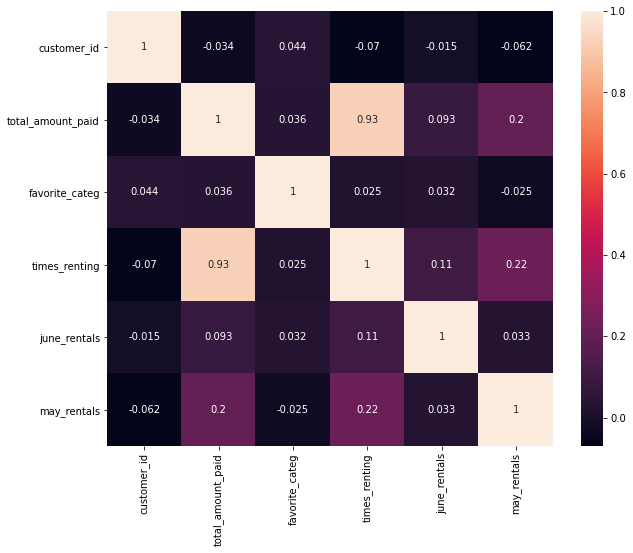

In [4]:
corr_matrix=data.corr(method='pearson')  # default
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

In [5]:
data.isna().sum()

customer_id          0
city                 0
total_amount_paid    0
favorite_categ       0
times_renting        0
june_rentals         0
may_rentals          0
dtype: int64

In [6]:
data = data.set_index('customer_id')

In [7]:
data

,city,total_amount_paid,favorite_categ,times_renting,june_rentals,may_rentals
customer_id,,,,,,
1,Sasebo,1661.52,4,448,1,2
2,San Bernardino,1673.49,15,351,1,1
3,Athenai,1764.62,1,338,1,2
4,Myingyan,1144.92,11,308,1,0
5,Nantou,2169.30,4,570,1,3
...,...,...,...,...,...,...
595,Jinzhou,1883.20,6,480,1,1
596,Patras,1354.08,15,392,1,6
597,Sullana,1296.75,9,325,1,2


In [8]:
data['favorite_categ'] = data['favorite_categ'].values.astype(str)
data['june_rentals'] = data['june_rentals'].values.astype(str)

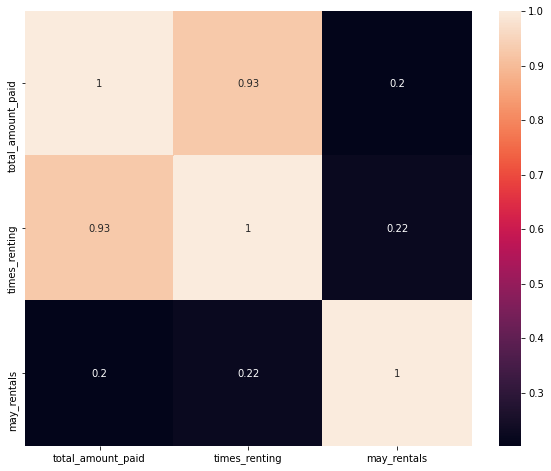

In [9]:
corr_matrix=data.corr(method='pearson')  # default
fig, ax = plt.subplots(figsize=(10, 8))
ax = sns.heatmap(corr_matrix, annot=True)
plt.show()

In [10]:
data1 = data.copy()

In [11]:
data1.dtypes

city                  object
total_amount_paid    float64
favorite_categ        object
times_renting          int64
june_rentals          object
may_rentals            int64
dtype: object

In [12]:
y = data1['june_rentals']
data1 = data1.drop('city', axis=1)
X = data1.drop(['june_rentals'], axis=1)
X = pd.get_dummies(data1)
#X = data1.drop(['june_rentals', 'total_amount_paid', 'times_renting', 'may_rentals'], axis=1)

In [13]:
X

,total_amount_paid,times_renting,may_rentals,favorite_categ_1,favorite_categ_10,favorite_categ_11,favorite_categ_12,favorite_categ_13,favorite_categ_14,favorite_categ_15,...,favorite_categ_2,favorite_categ_3,favorite_categ_4,favorite_categ_5,favorite_categ_6,favorite_categ_7,favorite_categ_8,favorite_categ_9,june_rentals_0,june_rentals_1
customer_id,,,,,,,,,,,,,,,,,,,,,
1,1661.52,448,2,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
2,1673.49,351,1,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
3,1764.62,338,2,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,1144.92,308,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
5,2169.30,570,3,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,1883.20,480,1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1
596,1354.08,392,6,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
597,1296.75,325,2,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,1


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [15]:
classification = LogisticRegression(random_state=42, max_iter = 600)

classification.fit(X_train, y_train)

LogisticRegression(max_iter=600, random_state=42)

In [16]:
classification.score(X_test, y_test)

0.9888888888888889

In [17]:
predictions = classification.predict(X_test)
predictions

array(['1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '0', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '0', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1',
       '1', '1', '1', '1', '1', '1', '1', '1', '1', '1', '1'],
 

In [18]:
predictions_ = classification.predict_proba(X_test)
predictions_

array([[6.50758552e-03, 9.93492414e-01],
       [8.45767172e-03, 9.91542328e-01],
       [1.35018223e-03, 9.98649818e-01],
       [3.12416315e-03, 9.96875837e-01],
       [6.37884605e-03, 9.93621154e-01],
       [2.95666600e-03, 9.97043334e-01],
       [9.26519180e-03, 9.90734808e-01],
       [1.85768099e-03, 9.98142319e-01],
       [9.33826753e-03, 9.90661732e-01],
       [7.62796797e-03, 9.92372032e-01],
       [1.65246732e-03, 9.98347533e-01],
       [1.07252836e-03, 9.98927472e-01],
       [4.51848762e-02, 9.54815124e-01],
       [4.73518307e-03, 9.95264817e-01],
       [1.10074774e-02, 9.88992523e-01],
       [5.57004061e-03, 9.94429959e-01],
       [5.71050415e-03, 9.94289496e-01],
       [4.33907098e-03, 9.95660929e-01],
       [8.90505651e-03, 9.91094943e-01],
       [2.23601950e-03, 9.97763980e-01],
       [3.25080838e-03, 9.96749192e-01],
       [3.71044448e-03, 9.96289556e-01],
       [1.04544579e-03, 9.98954554e-01],
       [2.12833716e-03, 9.97871663e-01],
       [4.987271

In [19]:
confusion_matrix(y_test, predictions) # normalize : {'true', 'pred', 'all'}

array([[  2,   2],
       [  0, 176]], dtype=int64)